In [1]:
import pandas as pd 
import numpy as np 
import awswrangler as wr
from datetime import date
import datetime

import mlflow
from mlflow.tracking import MlflowClient

import lightgbm as lgb
import joblib
from sklearn.metrics import roc_auc_score, confusion_matrix

import pickle 
import boto3

In [2]:
data_ant = wr.s3.read_parquet('s3://rimac-analytics-temporal/individuals/AnthonyRuiz/vehi/score/base_modelo_score_vehicular.parquet')


In [3]:
data_cross_ant = wr.s3.read_parquet('s3://rimac-analytics-temporal/individuals/AnthonyRuiz/vehi/score/df_revis_Dante.parquet.gz')


In [4]:
data_cross_ant[data_cross_ant.placa == 'AMJ508']

,cuc,placa,periodo,flg_cross
161,1-09880600,AMJ508,202012,True


In [5]:
q = """
select *
from coe_analytics_tmp.crossveh_test_back;
"""

data = wr.athena.read_sql_query(q, database="bdax_acselx")

In [6]:
print('Data sample:', data_ant.shape)
print('Total potencial cross:', data.shape)

Data sample: (398574, 7)
Total potencial cross: (1823084, 5)


In [7]:
print('Data sample:', data_ant.shape)
print('Total potencial cross:', data.shape)

Data sample: (398574, 7)
Total potencial cross: (1823084, 5)


In [7]:
data['periodo'] = data['periodo_target'].astype(str)
data_cross_ant['periodo'] = data_cross_ant['periodo'].astype(str)

In [8]:
 data_cross_ant.shape, data_cross_ant.drop_duplicates(['cuc', 'placa', 'periodo']).shape

((398574, 4), (395040, 4))

In [14]:
data_cross = pd.merge(data_cross_ant[data_cross_ant.flg_cross == True].drop_duplicates(['cuc', 'placa', 'periodo']), data[['cuc', 'placa', 'preds', 'periodo']].drop_duplicates(['cuc', 'placa', 'periodo']), on=['cuc','placa', 'periodo'], how='left')


In [25]:
data_faltante = pd.merge(data_cross.loc[(data_cross.preds.isnull())][['cuc', 'placa', 'periodo']], data[['cuc', 'placa', 'preds']].drop_duplicates(['cuc', 'placa']), on=['cuc', 'placa'], how='left')


In [41]:
data_cross.shape

(38750, 5)

In [38]:
data_faltante.shape

(20090, 4)

In [42]:
data_concat = pd.concat((data_cross[(data_cross.preds.notnull())], data_faltante), axis=0)

In [48]:
data_concat.shape

(38750, 5)

In [50]:
data_concat[data_concat.placa != 'XXXXXX'].shape

(29301, 5)

<AxesSubplot:>

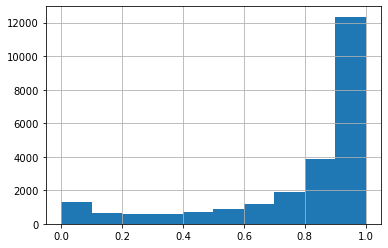

In [52]:
data_concat[(data_concat.preds.notnull())].preds.hist()

In [55]:
data_concat.preds.median()

0.9044595215405195

In [47]:
wr.s3.to_parquet(
        df=data_concat,
        path=f's3://rimac-analytics-temporal/individuals/Dante/cross_prop_veh/tmp/cross_tmp_01/',
        mode='overwrite',
        dataset=True,
        database="coe_analytics_tmp",
        table=f"cross_tmp_01"
)

{'paths': ['s3://rimac-analytics-temporal/individuals/Dante/cross_prop_veh/tmp/cross_tmp_01/92a6ad3e09e845df8a51890428d80f5c.snappy.parquet'],
 'partitions_values': {}}

In [23]:
data_faltante.shape

(20090, 4)

In [29]:
data_faltante[(data_faltante.preds.isnull()) & (data_faltante.placa != 'XXXXXX')].shape

(5207, 4)

In [30]:
data_faltante[(data_faltante.placa == 'XXXXXX')].shape

(9038, 4)

In [34]:
data_cross[(data_cross.placa != 'XXXXXX')].shape

(29301, 5)

In [35]:
5000 / 29000

0.1724137931034483

In [28]:
data[data.placa == 'AMJ508']

,periodo_target,cuc,placa,target,preds,periodo
354432,201903,1-08773200,AMJ508,0.0,0.590528,201903


In [ ]:
data_cross.loc[(data_cross.preds.isnull()) & ][['cuc', 'placa']]

In [16]:
data_cross_ant.flg_cross.sum()

39046

In [22]:
d = data.groupby(['placa', 'cuc'])[['periodo']].count().reset_index()

In [27]:
data_tmp = pd.merge(data_cross_ant.drop_duplicates(['cuc', 'placa', 'periodo']), d, on=['placa', 'cuc'])

In [29]:
data_tmp[data_tmp.flg_cross ==True].shape

(22568, 5)

In [30]:
data_tmp.shape

(223736, 5)

In [26]:
d[d.periodo > 1].head()

,placa,cuc,periodo
313,00103P,1-45120979,3
1028,00325A,1-08255264,4
1224,00388C,1-09884859,2
1726,00554C,1-44964881,2
2279,00723V,1-29637520,2


In [8]:
print('Cantidad nulos:', data_cross.preds.isnull().sum())
print('Cantidad cruce:', data_cross.preds.notnull().sum())

Cantidad nulos: 357528
Cantidad cruce: 37512


In [12]:
print('Cantidad nulos:', data_cross.preds.isnull().sum())
print('Cantidad cruce:', data_cross.preds.notnull().sum())

Cantidad nulos: 374793
Cantidad cruce: 20247


In [13]:
print('Cantidad nulos:', data_cross.preds.isnull().sum())
print('Cantidad cruce:', data_cross.preds.notnull().sum())

Cantidad nulos: 374793
Cantidad cruce: 20247


In [10]:
data_cross[data_cross.flg_cross == True].preds.notnull().sum()

18660

In [10]:
data_cross[data_cross.flg_cross == True].preds.notnull().sum()

17166

In [11]:
data_cross[(data_cross.flg_cross == True) & (data_cross.preds.isnull()) & (data_cross.placa != 'XXXXXX')].head()

,cuc,placa,periodo,flg_cross,preds
161,1-09880600,AMJ508,202012,True,NaN
164,1-44081976,F0B087,202012,True,NaN
322,1-19870123,F5X092,202010,True,NaN
324,1-44243547,BEG283,201808,True,NaN
351,1-07446315,ADP525,201801,True,NaN


In [33]:
data_cross[(data_cross.flg_cross == True) & (data_cross.preds.isnull()) & (data_cross.placa != 'XXXXXX')].head()

,cuc,placa,periodo,flg_cross,preds
161,1-09880600,AMJ508,202012,True,NaN
164,1-44081976,F0B087,202012,True,NaN
268,1-44956524,BTD094,202012,True,NaN
316,1-40312066,BSD665,202010,True,NaN
322,1-19870123,F5X092,202010,True,NaN


In [13]:
data[data.cuc == '1-07446315']

,periodo_target,cuc,placa,target,preds,periodo
314449,201601,1-07446315,C1O195,1.0,0.791279,201601
322345,201904,1-07446315,B7Z895,1.0,0.098122,201904
322355,201904,1-07446315,C1O195,1.0,0.165483,201904
920399,201601,1-07446315,ADP525,1.0,0.909112,201601
1051462,201601,1-07446315,ADP525,1.0,0.909112,201601
1390558,201601,1-07446315,LQ5763,1.0,0.137792,201601
1555179,201904,1-07446315,ADP525,1.0,0.613150,201904
1711235,201904,1-07446315,C1O195,1.0,0.165483,201904


In [16]:
data_cross[(data_cross.flg_cross == True) & (data_cross.placa == 'XXXXXX')].shape

(9038, 5)

In [11]:
data_cross.flg_cross.sum()

38750

In [14]:
data_cross[(data_cross.preds.notnull()) & (data_cross.flg_cross == False)].shape

(11239, 5)

In [15]:
data_cross[(data_cross.preds.notnull()) & (data_cross.flg_cross == True)].shape

(9008, 5)

In [25]:
data_cross[(data_cross.preds.notnull())].preds.median()

0.8938915197773527

In [20]:
data_cross[(data_cross.preds.notnull())].preds.max()

0.9997059032449844

In [20]:
data_cross[(data_cross.preds.notnull())].preds.max()

0.9997059032449844

In [44]:
data_cross[(data_cross.flg_cross == True) & (data_cross.placa != 'XXXXXX')].shape

(29301, 6)

In [26]:
df_temp = data_cross[(data_cross.preds.notnull())].reset_index(drop=True).copy()
df_temp['decile'] = pd.cut(df_temp.preds, [1.49895563e-05, 5.33033580e-03, 1.11263409e-02, 2.06319170e-02,
       3.71802842e-02, 6.63849774e-02, 1.24757035e-01, 2.55074497e-01,
       5.43542687e-01, 8.91139470e-01, 9.99757476e-01])

In [27]:
df_temp.groupby(['decile'])[['cuc']].count()

,cuc
decile,
"(1.5e-05, 0.00533]",332
"(0.00533, 0.0111]",247
"(0.0111, 0.0206]",228
"(0.0206, 0.0372]",172
"(0.0372, 0.0664]",193
"(0.0664, 0.125]",212
"(0.125, 0.255]",523
"(0.255, 0.544]",1540
"(0.544, 0.891]",6535


In [9]:
data_cross.shape

(395040, 5)

In [28]:
20247 / 29301

0.6910003071567523

In [52]:
data[(data.placa == 'AMJ508')].head()

,periodo_target,cuc,placa,target,preds,periodo
1546951,201903,1-08773200,AMJ508,0.0,0.546973,201903


In [53]:
data_cross_ant[(data_cross_ant.placa == 'AMJ508')].head()

,cuc,placa,periodo,flg_cross
161,1-09880600,AMJ508,202012,True


In [16]:
print('Cantidad nulos:', data_cross.preds.isnull().sum())
print('Cantidad cruce:', data_cross.preds.notnull().sum())

Cantidad nulos: 380313
Cantidad cruce: 18261


In [29]:
#Reescalamiento de probabilidades
def rescaling(prob,corte):
    if prob<corte:
        a,b,c,d = 0,corte, 0,.5
    else:
        a,b,c,d = corte, 1 , 0.5,1
    return (prob-a) / (b-a) * (d-c) + c

In [31]:
corte = 0.05495982984048662


In [50]:
data_cross['pred_rescaling'] = data_cross['preds'].apply(lambda prob: rescaling(prob, corte))

In [51]:
data_cross[data_cross.preds.notnull()].head()

,cuc,placa,periodo,flg_cross,preds,pred_rescaling
19,1-32643723,BCA608,201804,False,0.996020,0.997894
51,1-44385354,D1A287,202005,True,0.926888,0.961318
56,1-43805414,BAW631,201907,True,0.936525,0.966417
122,1-41186696,C3Z298,201806,True,0.996080,0.997926
131,1-45802751,AJW591,202002,True,0.653102,0.816464


In [49]:
wr.s3.to_parquet(
        df=data_cross,
        path=f's3://rimac-analytics-temporal/individuals/Dante/cross_prop_veh/temp/unificacion_tmp/',
        mode='overwrite',
        dataset=True,
        database="coe_analytics_tmp",
        table=f"cross_veh_tmp"
)

{'paths': ['s3://rimac-analytics-temporal/individuals/Dante/cross_prop_veh/temp/unificacion_tmp/9c511382ec6b4d35b5dde3cf65da6c33.snappy.parquet'],
 'partitions_values': {}}